##### Publication trends forecasting outputs

* Train+val+test Data covers ~1960-2019.
    * Model/features optimized over 1980-2010

* Prediction 5 years (inclusive) in advance

* Temporal split over data

* `y_raw` = Actual amount of publications (normalized out of total pubs that year in pubmed)
* `preds` = model predictions


* SparkBeyond Validation set ~ 2010-2013 , Test set 2014-2019
    * SB Train+val+test Data covers 1980-2019.
    * Raw/context data covers more (and I output that here)
* Prediction 5 years (inclusive) in advance


 * I try redoing time series CV/split here from scratch , to better show predicitons. 
     * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import cross_val_predict,TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import Pipeline
import numpy as np

In [35]:
def plot_var_preds(df,val:str="subthalamus"):
#     df.loc[df["variable"].str.contains(val,case=False)][["y_raw","preds"]].plot(title=val)# "y_raw_predicted"
    df.loc[df["variable"].str.lower()==val.lower()][["y_raw","preds"]].plot(title=val)

In [3]:
df_feat = pd.read_csv("trends_demo_rev22_predicted.tsv.gz",sep="\t",parse_dates=["Year","first","start"])

df_feat = df_feat.loc[df_feat["Year"]>= df_feat["start"]]
df_feat = df_feat.loc[(df_feat["Year"]>= df_feat["start"]) & (df_feat["year_num"]>= 1960) ].reset_index(drop=True)

df_feat.sort_values("Year",inplace=True,ascending=True) ## sort by year , not topic
df_feat["variable"] = df_feat["variable"].str.strip('"')

df = df_feat.filter(['Year', 'variable', 'y_raw',"preds",'y_raw_predicted',  'first', 'start', 'year_num',
               "pct_diff_lag6"],axis=1).set_index("Year").copy()

df.rename(columns={"y_raw_predicted":"preds"},inplace=True)
df

,variable,y_raw,preds,first,start,year_num
Year,,,,,,
1960-01-01 00:00:00+00:00,BLAST,10.693,14.983438,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,influenza,360.001,435.692230,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,lateral ventricles,10.693,12.378796,1946-01-01 00:00:00+00:00,1951-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,LSD,58.812,209.426529,1950-01-01 00:00:00+00:00,1955-01-01 00:00:00+00:00,1960
1960-01-01 00:00:00+00:00,lipid,2200.994,1960.983276,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1960
...,...,...,...,...,...,...
2019-01-01 00:00:00+00:00,inflammatory,4105.101,3902.605713,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019
2019-01-01 00:00:00+00:00,RNA,4565.569,5554.289551,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019
2019-01-01 00:00:00+00:00,influenza,426.964,698.016235,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019


In [4]:
df_feat = df_feat.filter(list(df_feat.select_dtypes(["number"]).columns)+["variable"],axis=1)
df_feat = df_feat.T.drop_duplicates().T.infer_objects() ## drop some duplicate cols
# df_feat["variable"] = df_feat["variable"].astype("category")

## drop y_raw_predicted ? 
display(df_feat.head(6))

,y_raw,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99),y_raw_predicted,variable
0,10.693,21.186,17.934,1960,0.340023,0.0,546.814903,26.806678,0.038587,5.175392e+05,...,8.390122e+07,0.435447,1.015355,0.000261,0.0,-0.097698,4161.713444,0.5,14.983438,BLAST
3635,360.001,399.772,473.844,1960,0.681334,0.0,546.814903,15.277181,0.207495,1.024360e+07,...,8.390122e+07,0.911149,2.454795,0.000261,0.0,-0.156323,18270.307612,0.5,435.692230,influenza
3792,10.693,8.290,11.327,1960,0.293297,0.0,546.814903,15.411140,0.026255,3.991985e+05,...,8.390122e+07,0.349600,1.015355,0.000261,0.0,-0.097698,2614.316178,0.5,12.378796,lateral ventricles
746,58.812,27.634,9.439,1960,0.302410,0.0,546.814903,27.633979,0.049849,8.828872e+05,...,8.390122e+07,0.355567,1.015355,0.000261,0.0,-0.097698,466.970599,0.5,209.426529,LSD
3852,2200.994,1825.685,1665.062,1960,0.100000,0.0,546.814903,15.277181,0.716440,4.563931e+07,...,8.390122e+07,1.000000,1.015355,0.000261,0.0,-0.049019,32772.417917,0.5,1960.983276,lipid
3912,11.584,23.028,13.215,1960,0.334145,0.0,546.814903,23.875466,0.032131,4.536846e+05,...,8.390122e+07,0.429448,1.015355,0.000261,0.0,-0.097698,1532.478004,0.5,32.926460,lithium


In [5]:
# df.groupby(["variable"])["y_raw"].transform("pct_change").reset_index()#.describe()
### highlky variable topics : 
# df.groupby(["variable"])["pct_diff_lag6"].std().sort_values(ascending=False)

In [6]:
df["variable"].unique()

array(['BLAST', 'influenza', 'lateral ventricles', 'LSD', 'lipid',
       'lithium', 'Insular cortex', 'Histamine', 'zebra fish',
       'ultrasound', 'microglia', 'mouse', 'multiple sclerosis',
       'natural medicine', 'GABA', 'inflammatory', 'neocortex', 'opioids',
       'Epidemiology', 'paleocortex', 'pineal gland', 'EEG',
       'pituitary gland', 'thalamus', 'race', 'ribosome', 'rnase',
       'serotonin', 'single cell', 'Cingulate cortex', 'sleep',
       'neuropeptide', 'somatosensory cortex', 'Medulla oblongata',
       'vaccine', 'antibiotic resistance', 'aquaphonic agriculture',
       'archaea', 'autism', 'autoimmune', 'amygdala', 'basal ganglia',
       'vitamin C', 'cannabis', 'acetylcholine', 'vitamin D',
       'cerebellum', 'cholesterol', 'cocaine', 'hypothalamus', 'coral',
       'Prefrontal cortex', 'viral therapy', 'epinephrine',
       'ethnic differences', 'eugenics', 'Orbitofrontal cortex',
       'gene therapy', 'genetic engineering', 'Norepinephrine',
       

In [7]:
df_feat

,y_raw,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99),y_raw_predicted,variable
0,10.693,21.186,17.934,1960,0.340023,0.000000,546.814903,26.806678,0.038587,5.175392e+05,...,8.390122e+07,0.435447,1.015355,0.000261,0.0,-0.097698,4161.713444,0.500000,14.983438,BLAST
3635,360.001,399.772,473.844,1960,0.681334,0.000000,546.814903,15.277181,0.207495,1.024360e+07,...,8.390122e+07,0.911149,2.454795,0.000261,0.0,-0.156323,18270.307612,0.500000,435.692230,influenza
3792,10.693,8.290,11.327,1960,0.293297,0.000000,546.814903,15.411140,0.026255,3.991985e+05,...,8.390122e+07,0.349600,1.015355,0.000261,0.0,-0.097698,2614.316178,0.500000,12.378796,lateral ventricles
746,58.812,27.634,9.439,1960,0.302410,0.000000,546.814903,27.633979,0.049849,8.828872e+05,...,8.390122e+07,0.355567,1.015355,0.000261,0.0,-0.097698,466.970599,0.500000,209.426529,LSD
3852,2200.994,1825.685,1665.062,1960,0.100000,0.000000,546.814903,15.277181,0.716440,4.563931e+07,...,8.390122e+07,1.000000,1.015355,0.000261,0.0,-0.049019,32772.417917,0.500000,1960.983276,lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,4105.101,3687.357,3677.723,2019,0.100000,0.000000,3685.780703,15.277181,0.414219,6.225771e+08,...,8.390122e+07,0.100000,0.641622,0.006794,0.0,-0.011935,324914.765004,0.246021,3902.605713,inflammatory
1291,4565.569,4727.542,4724.836,2019,0.100000,0.000000,4795.293249,15.277181,0.477330,6.089963e+08,...,8.390122e+07,0.100000,0.044262,0.005551,0.0,-0.043066,316396.924233,0.140074,5554.289551,RNA
3694,426.964,517.023,566.044,2019,0.929199,0.000000,715.476912,15.277181,0.571395,1.352648e+08,...,3.664393e+08,0.100000,0.128093,0.000059,249.0,-0.117213,64210.897604,0.221366,698.016235,influenza
3494,33.279,26.375,24.174,2019,0.559896,1.975044,546.814903,23.247692,0.008728,5.626786e+06,...,4.027977e+07,0.454031,0.645140,0.000215,0.0,-0.097698,2807.003064,1.000000,132.785629,hydrophonics


### temporal CV

* https://stackoverflow.com/questions/41753795/sklearn-timeseriessplit-cross-val-predict-only-works-for-partitions

In [8]:
num_cols = list(df_feat.select_dtypes("number").drop(columns=["y_raw","y_raw_predicted","preds"],errors="ignore").columns)

# X = df_feat.filter(["variable"]+num_cols,axis=1).copy()

X = df_feat[["variable"]+num_cols].copy()
# X = X.fillna(0)
y = df_feat["y_raw"]#.values

# ## https://stackoverflow.com/questions/41753795/sklearn-timeseriessplit-cross-val-predict-only-works-for-partitions
# preds = cross_val_predict(clf,X.fillna(0),y,cv=cv.split(df_feat))

In [9]:
X

,variable,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,maxSlope(detrend(research_review_diff of variable between 20 years and 5 years before Year)),recentVSHistoricalMedianDifference(reviews of variable between all past years and 5 years before Year),"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99)
0,BLAST,21.186,17.934,1960,0.340023,0.000000,546.814903,26.806678,0.038587,5.175392e+05,...,0.044466,0.000000,8.390122e+07,0.435447,1.015355,0.000261,0.0,-0.097698,4161.713444,0.500000
3635,influenza,399.772,473.844,1960,0.681334,0.000000,546.814903,15.277181,0.207495,1.024360e+07,...,0.192533,0.000000,8.390122e+07,0.911149,2.454795,0.000261,0.0,-0.156323,18270.307612,0.500000
3792,lateral ventricles,8.290,11.327,1960,0.293297,0.000000,546.814903,15.411140,0.026255,3.991985e+05,...,0.024701,0.000000,8.390122e+07,0.349600,1.015355,0.000261,0.0,-0.097698,2614.316178,0.500000
746,LSD,27.634,9.439,1960,0.302410,0.000000,546.814903,27.633979,0.049849,8.828872e+05,...,0.038811,0.000000,8.390122e+07,0.355567,1.015355,0.000261,0.0,-0.097698,466.970599,0.500000
3852,lipid,1825.685,1665.062,1960,0.100000,0.000000,546.814903,15.277181,0.716440,4.563931e+07,...,0.502524,0.000000,8.390122e+07,1.000000,1.015355,0.000261,0.0,-0.049019,32772.417917,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,inflammatory,3687.357,3677.723,2019,0.100000,0.000000,3685.780703,15.277181,0.414219,6.225771e+08,...,0.223353,602.683012,8.390122e+07,0.100000,0.641622,0.006794,0.0,-0.011935,324914.765004,0.246021
1291,RNA,4727.542,4724.836,2019,0.100000,0.000000,4795.293249,15.277181,0.477330,6.089963e+08,...,0.480361,194.670740,8.390122e+07,0.100000,0.044262,0.005551,0.0,-0.043066,316396.924233,0.140074
3694,influenza,517.023,566.044,2019,0.929199,0.000000,715.476912,15.277181,0.571395,1.352648e+08,...,0.515254,42.810645,3.664393e+08,0.100000,0.128093,0.000059,249.0,-0.117213,64210.897604,0.221366
3494,hydrophonics,26.375,24.174,2019,0.559896,1.975044,546.814903,23.247692,0.008728,5.626786e+06,...,0.005944,0.260872,4.027977e+07,0.454031,0.645140,0.000215,0.0,-0.097698,2807.003064,1.000000


In [10]:
# cv = TimeSeriesSplit(n_splits=5)
# clf = Ridge(alpha=0.5) # HistGradientBoostingRegressor
# clf =HistGradientBoostingRegressor(categorical_features=categorical_mask)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

## https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py
X["variable"] = X["variable"].astype("category")

n_categorical_features = X.select_dtypes(include="category").shape[1] # 1 
categorical_mask = [True] * 1 + [False] * (X.shape[1]-1) # 133 , categorical is first feat

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

clf = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state=42, categorical_features=categorical_mask
    ),
)

In [11]:
%%time 
tscv = TimeSeriesSplit(11)
# df_feat["preds"] = np.NaN

def evaluate(model):
    """https://stats.stackexchange.com/questions/495151/cross-validation-for-time-series-what-am-i-doing-wrong"""
    # train model on training dataset
    i = 0
    for train_index, test_index in tscv.split(df_feat):
        i +=1
        if i%3==0: print(i)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        df_feat.loc[test_index,"preds"] =y_predict  ## ??
#         predict_values = [round(value) for value in y_predict]
#         # calculate accuracy
#         accuracy = accuracy_score(y_test, predict_values)
#         print("Accuracy: %.2f%%" % (accuracy * 100.0))
        # confusion matrix
#         print("Confusion Matrix:")
#         conf_matrix = confusion_matrix(y_test, y_predict)
#         print(conf_matrix)

evaluate(model=clf)

display(df_feat[["year_num","y_raw","preds","y_raw_predicted","variable"]].dropna(axis=0))

print(df_feat[["year_num","y_raw","preds","y_raw_predicted"]].corrwith(df_feat["y_raw"]).round(3).sort_values())

3
6
9


,year_num,y_raw,preds,y_raw_predicted,variable
3635,1960,360.001,531.954836,435.692230,influenza
3792,1960,10.693,9.670531,12.378796,lateral ventricles
746,1960,58.812,30.454511,209.426529,LSD
3852,1960,2200.994,2552.928342,1960.983276,lipid
3912,1960,11.584,8.939169,32.926460,lithium
...,...,...,...,...,...
3634,2019,4105.101,5588.320772,3902.605713,inflammatory
1291,2019,4565.569,3585.339807,5554.289551,RNA
3694,2019,426.964,345.279571,698.016235,influenza
3494,2019,33.279,34.371861,132.785629,hydrophonics


year_num           0.108
preds              0.914
y_raw_predicted    0.987
y_raw              1.000
dtype: float64
CPU times: total: 2min 57s
Wall time: 36.5 s


In [12]:
df_feat.set_index("year_num",inplace=True)

In [13]:
df_feat["y_raw"].notna().sum()

6241

### Plot Predictions


In [14]:
df_feat["preds"].notna().sum()

5720

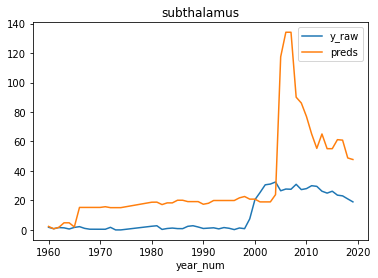

In [15]:
plot_var_preds(df_feat,"subthalamus")

In [16]:
# df_feat.loc[df_feat["variable"].str.contains("subthalamus",case=False)]#[["y_raw","y_raw_predicted"]]

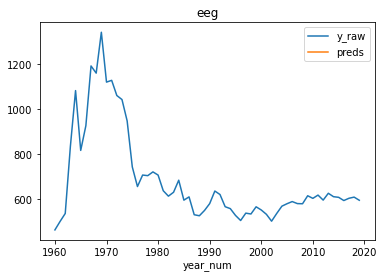

In [17]:
plot_var_preds(df_feat,"eeg")

In [18]:
# df.loc[df["variable"].str.contains("neural networks",case=False)][["y_raw","y_raw_predicted"]].plot(title="neural networks")

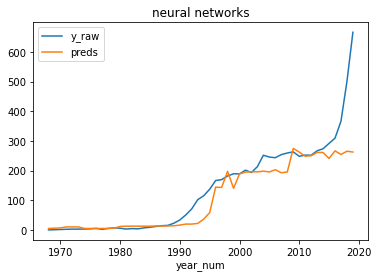

In [36]:
plot_var_preds(df_feat,"neural networks")

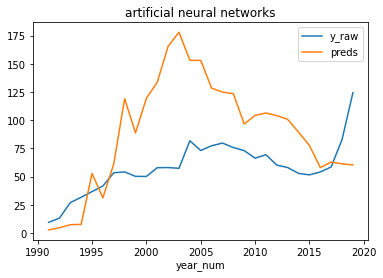

In [37]:
plot_var_preds(df_feat,"artificial neural networks")

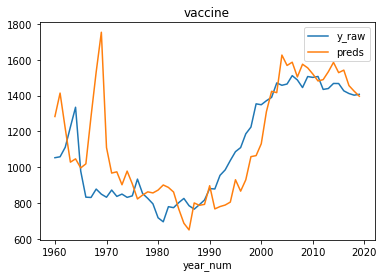

In [21]:
plot_var_preds(df_feat,"vaccine")

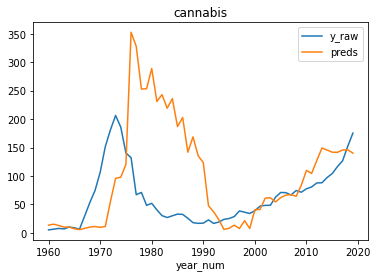

In [22]:
plot_var_preds(df_feat,"cannabis")

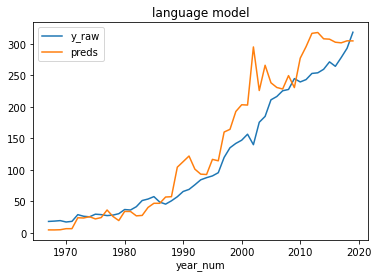

In [23]:
plot_var_preds(df_feat,"language model")

In [24]:
df.loc[df["start"].dt.year>1990]["variable"].unique()

array(['artificial neural networks', 'graph neural network', 'buckyballs',
       'carbon nanotubes', 'BRCA2', 'BRCA1', 'GWAS', 'illumina',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9'], dtype=object)

In [25]:
# df_feat.loc[df_feat["variable"]=="BRCA1"] ## why no preds?

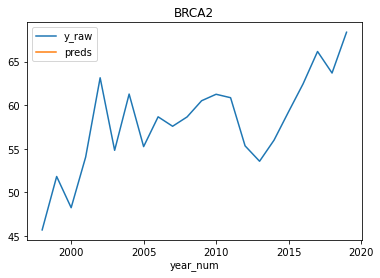

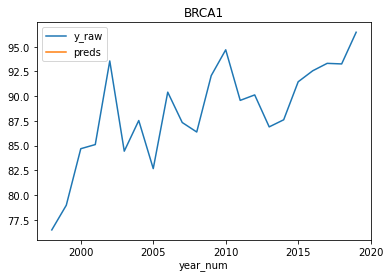

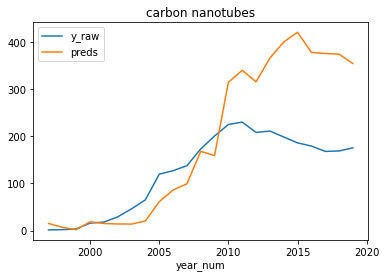

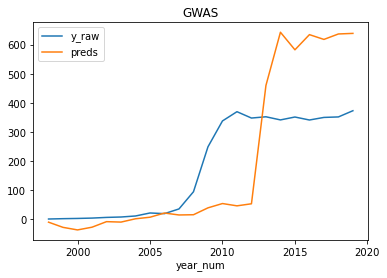

In [26]:
for i in ['BRCA2', 'BRCA1', 'carbon nanotubes', 'GWAS']:
    plot_var_preds(df_feat,i)

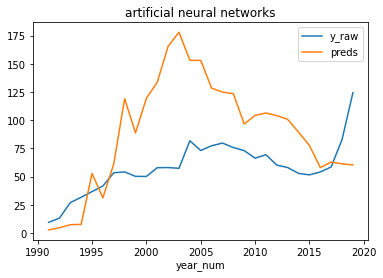

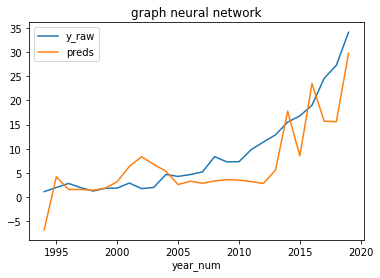

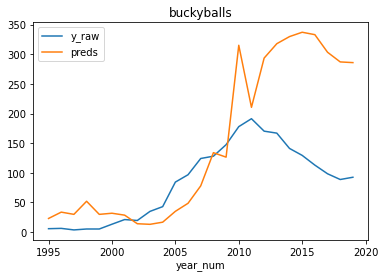

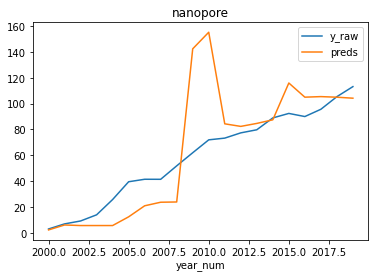

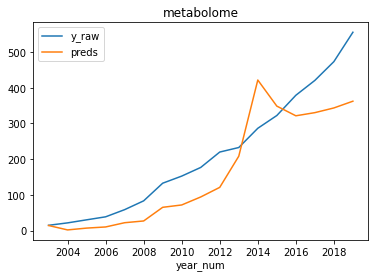

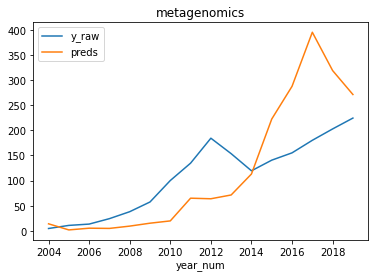

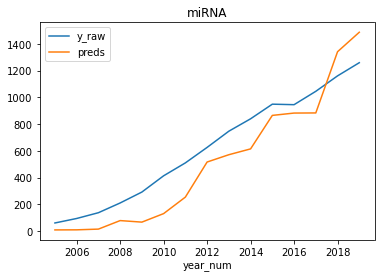

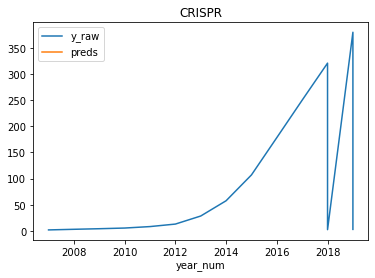

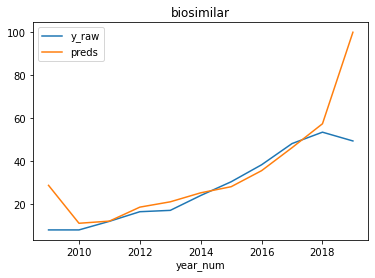

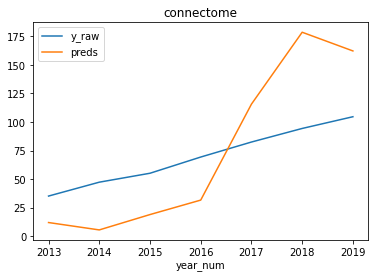

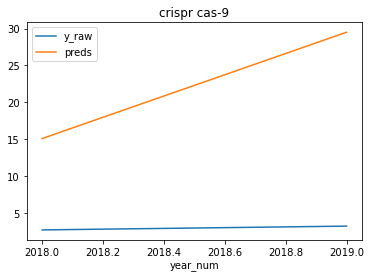

In [27]:
for i in ['artificial neural networks', 'graph neural network', 'buckyballs',
#        'carbon nanotubes', 'BRCA2', 'BRCA1', 'GWAS',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9',]:
    plot_var_preds(df_feat,i)

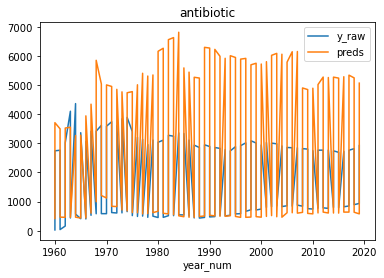

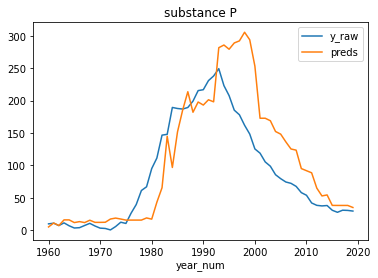

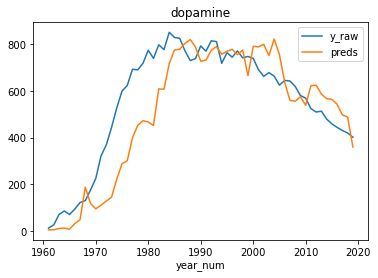

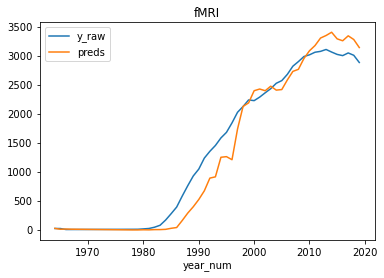

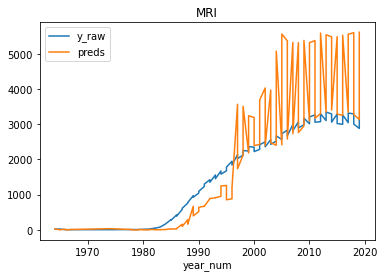

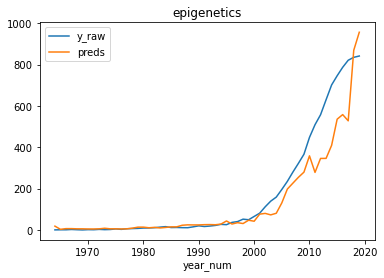

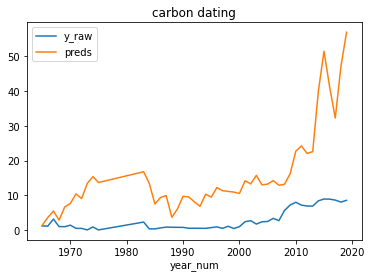

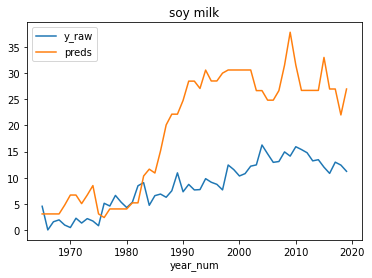

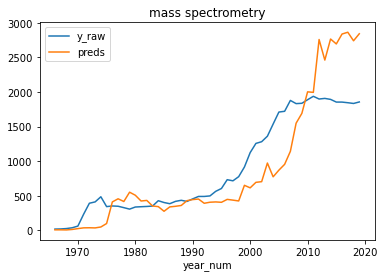

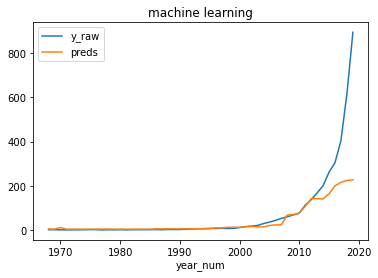

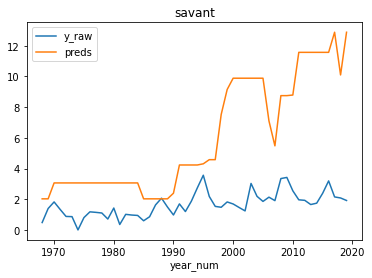

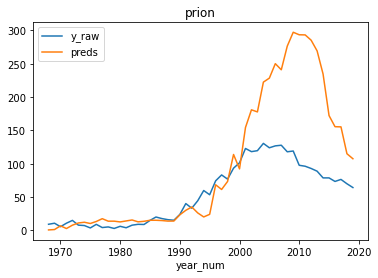

In [28]:
for i in ['antibiotic','substance P', 'dopamine', 'fMRI', 'MRI', 'epigenetics',
       'carbon dating', 'soy milk', 'mass spectrometry', 
       'machine learning', 'savant', 'prion']:
    plot_var_preds(df_feat,i)

In [34]:
df_feat.loc[df_feat["variable"].str.contains("neural networks",case=False)][["variable","y_raw","preds"]]

,variable,y_raw,preds
year_num,,,
1968,neural networks,0.000,4.917593
1970,neural networks,1.367,6.786114
1971,neural networks,2.236,10.213317
1972,neural networks,2.633,10.096344
1973,neural networks,2.596,10.096344
...,...,...,...
2017,neural networks,366.520,254.411250
2018,artificial neural networks,82.857,61.287354
2018,neural networks,500.485,265.236215
